In [117]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [118]:
import numpy as np
import pandas as pd

In [119]:
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [120]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [121]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [122]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [123]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [124]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [125]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [126]:
# Getting column names

mrow = session.query(Measurement).first()

srow = session.query(Station).first()
mrow.__dict__, srow.__dict__

({'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1c234c343c8>,
  'prcp': 0.08,
  'station': 'USC00519397',
  'tobs': 65.0,
  'date': '2010-01-01',
  'id': 1},
 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1c234c34a58>,
  'elevation': 3.0,
  'latitude': 21.2716,
  'station': 'USC00519397',
  'id': 1,
  'longitude': -157.8168,
  'name': 'WAIKIKI 717.2, HI US'})

# Exploratory Climate Analysis

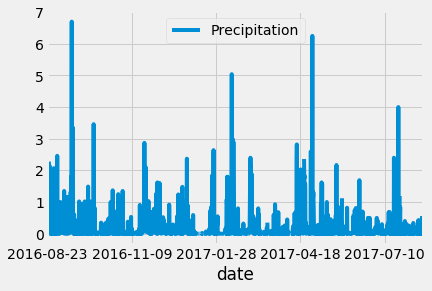

In [127]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Fnding the latest date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc())[0][0]
latest_date_ = dt.datetime.strptime(latest_date, '%Y-%m-%d')

last_year = latest_date_ - timedelta(days = 365)
last_year_str = last_year.strftime('%Y-%m-%d')


# Perform a query to retrieve the data and precipitation scores

prcp_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=last_year_str).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

dt_prcp_data = pd.DataFrame(prcp_data)
dt_prcp_data.set_index('date')

# Sort the dataframe by date

dt_prcp_data.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data

fig = dt_prcp_data.plot('date', 'prcp')
plt.legend(["Precipitation"])
plt.show()



In [128]:
# Use Pandas to calcualte the summary statistics for the precipitation data

dt_prcp_data.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [142]:
# Design a query to show how many stations are available in this dataset?

no_of_stations = session.query(Station.station).all()
len(np.unique(no_of_stations))

9

In [145]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
                                order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [156]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


stats = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
stats


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

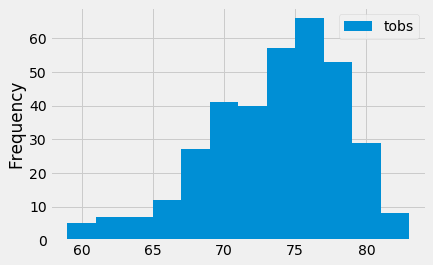

In [196]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stats_t = session.query(Measurement.tobs, Measurement.date).filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date>=last_year_str).all()

df_stats_t = pd.DataFrame(stats_t)

df_stats_t.plot.hist(bins=12)
plt.xticks(np.arange(60, 85, 5))
plt.yticks(np.arange(0, 70, 10))
plt.show()


In [197]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [200]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2011-02-28', '2011-03-05')
trip

[(61.0, 69.75510204081633, 75.0)]

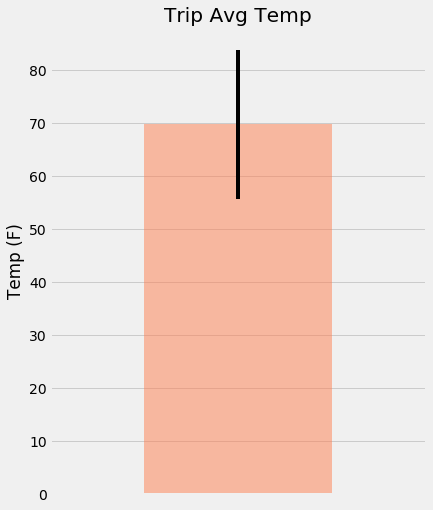

In [203]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


trip_df = pd.DataFrame(trip, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks([])
plt.show()

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]
